In [19]:
import pandas as pd
from math import sqrt
import numpy as np
from scipy.stats import norm
import seaborn as sns

In [56]:
# download annual historical data for the stonk
df = pd.read_csv("F.csv")
df = df.sort_values(by="Date")
df = df.dropna()
# calculate returns
df = df.assign(close_day_before=df.Close.shift(1))
df['returns'] = ((df.Close - df.close_day_before)/df.close_day_before)

#r = df
# get options data from yahoo finance // in this case, exercise data is Oct 16th
option_url = 'https://finance.yahoo.com/quote/F/options?p=F&date=1602806400'
r = pd.read_html(option_url)[0]
strike_date_unix = int(option_url.split('=')[-1])

In [57]:
test =df.Date.astype('datetime64[ns]').astype('int') / 10**9
days = int((strike_date_unix - test.max()) / (60*60*24))
print('{} days to strike date'.format(days))

53 days to strike date


## Black-Scholes

In [58]:
# S is the spot price 
# K is the strike price 
# T is the fraction of days to strike date divided by 252 (stock market days)
# r is the risk free rate (10Y Treasure Yield (0.69%))
# sigma is the annual volatility of the returns of the stock 

def black_scholes(S, K, T, r, sigma):
    d1 = np.log(S/(K/(1 + r)**T)/(sigma*sqrt(T))) + (sigma*sqrt(T))/2
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - (K/(1 + r)**T) * norm.cdf(d2)

In [59]:
# Calculate the volatility as the annualized standard deviation of the stock returns
sigma = np.sqrt(252) * df['returns'].std()

list_estimates = []

# currently 13 different strike prices for call contracts 
for x in range(0,13):
    value_s = black_scholes(S = 8, 
                            K = r['Strike'][x], 
                            T = (days/252), 
                            r = 0.0069, 
                            sigma = sigma)
    list_estimates.append(value_s)
    

# merge the two lists to compare results
df_list = pd.DataFrame(data=list_estimates, index=r.index)
df_list['estimate'] = df_list[0]
del df_list[0]
df_estimate = r.merge(df_list, right_index = True, left_index = True)

In [60]:
df_estimate

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,estimate
0,F201016C00001000,2020-08-06 3:04PM EDT,1.0,6.05,6.00,6.10,0.00,-,1,3,312.50%,7.000547
1,F201016C00002000,2020-08-11 10:32AM EDT,2.0,5.35,4.95,5.05,0.00,-,2,5,150.00%,5.995973
2,F201016C00003000,2020-08-19 9:38AM EDT,3.0,3.90,4.00,4.10,0.00,-,1,6,141.41%,4.990980
3,F201016C00004000,2020-08-24 3:41PM EDT,4.0,3.02,3.00,3.10,0.00,-,27,183,99.22%,3.997031
4,F201016C00005000,2020-08-24 3:55PM EDT,5.0,2.03,2.04,2.09,0.00,-,5,0,69.14%,3.025234
5,F201016C00006000,2020-08-25 10:02AM EDT,6.0,1.16,1.15,1.16,0.03,+2.65%,19,1704,52.34%,2.084184
6,F201016C00007000,2020-08-25 9:57AM EDT,7.0,0.48,0.44,0.47,0.05,+11.63%,373,13711,44.73%,1.179845
7,F201016C00008000,2020-08-25 10:04AM EDT,8.0,0.14,0.13,0.14,0.01,+7.69%,967,0,42.97%,0.315979
8,F201016C00009000,2020-08-25 9:52AM EDT,9.0,0.05,0.04,0.05,0.01,+25.00%,127,9051,46.88%,-0.505350
9,F201016C00010000,2020-08-25 9:43AM EDT,10.0,0.02,0.02,0.03,0.00,-,96,8788,52.73%,-1.283324


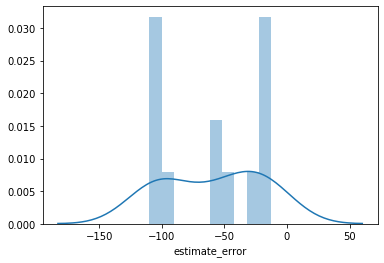

In [61]:
df_estimate['estimate_error'] = ((df_estimate['Ask'] - df_estimate['estimate'])/df_estimate['estimate'])*100
df_estimate['estimate_error'].describe()
ax = sns.distplot(df_estimate['estimate_error'],bins=10)

In [25]:
df_estimate.describe()

,Strike,Last Price,Bid,Ask,Change,Volume,Open Interest,estimate,estimate_error
count,13.00000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,7.00000,1.711538,1.681538,1.712308,0.008462,114.076923,5150.692308,1.431489,-59.720744
std,3.89444,2.183372,2.141393,2.162580,0.014632,253.559481,9081.269261,3.405606,38.299940
min,1.00000,0.020000,0.000000,0.000000,0.000000,1.000000,3.000000,-3.386383,-109.701876
25%,4.00000,0.020000,0.020000,0.030000,0.000000,1.000000,56.000000,-1.296726,-100.732237
50%,7.00000,0.470000,0.450000,0.460000,0.000000,3.000000,690.000000,1.175308,-57.920465
75%,10.00000,3.020000,3.000000,3.100000,0.010000,96.000000,8788.000000,3.996744,-22.436867
max,13.00000,6.050000,6.000000,6.050000,0.040000,904.000000,31347.000000,7.000546,-13.578167


In [25]:
df1 = df_estimate[(df_estimate.Volume != '-')]

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [26]:
df1.describe()

,Strike,Last Price,Bid,Ask,Change,Volume,Open Interest,estimate_1,estimate_error
count,13.00000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,7.00000,1.701538,1.657692,1.696154,0.075385,880.538462,4737.076923,1.333814,-58.475708
std,3.89444,2.188252,2.124375,2.162227,0.105721,2075.157127,8104.035841,3.507886,37.808004
min,1.00000,0.010000,0.000000,0.000000,-0.010000,1.000000,2.000000,-3.709116,-106.275263
25%,4.00000,0.020000,0.020000,0.030000,0.000000,2.000000,56.000000,-1.462146,-100.269606
50%,7.00000,0.440000,0.430000,0.440000,0.000000,179.000000,496.000000,1.121989,-44.943877
75%,10.00000,3.020000,2.980000,3.050000,0.130000,256.000000,8577.000000,3.994290,-23.641006
max,13.00000,6.050000,5.950000,6.050000,0.300000,7523.000000,27471.000000,7.000514,-13.577778
